Aliasing and zero padding: a hands-on mini tutorial

We will:
- Build two cosine waves on a coarse periodic grid
- Multiply them and see aliasing in the spectrum
- Apply zero padding (3/2-rule) to upsample before multiplying, then truncate back
- Compare spectra and the recovered coarse-grid product


In [1]:
using FFTW
using LinearAlgebra
using Statistics
using Random
using Plots

# helper: compute DFT frequency indices centered [-K:K]
function fftfreq_indices(N::Int)
    k = collect(0:N-1)
    k .-= (N ÷ 2)
    circshift(k, N ÷ 2)
end

# helper: shift-zero-centered spectrum for plotting
function fftshift(v)
    circshift(v, length(v) ÷ 2)
end

# zero-pad (symmetric) Fourier vector from length N to M (M >= N)
# X is in unshifted FFT order
function pad_fourier(X::AbstractVector, M::Int)
    N = length(X)
    @assert M >= N "M must be >= N"
    Y = zeros(eltype(X), M)
    # place low frequencies
    half = N ÷ 2
    Y[1:half+1] .= X[1:half+1]       # DC .. Nyquist (if even length)
    Y[end-(half-1):end] .= X[half+2:end]
    return Y
end

# truncate from M to N (keep lowest N modes), inverse of pad_fourier
function truncate_fourier(Y::AbstractVector, N::Int)
    M = length(Y)
    @assert M >= N
    X = zeros(eltype(Y), N)
    half = N ÷ 2
    X[1:half+1] .= Y[1:half+1]
    X[half+2:end] .= Y[end-(half-1):end]
    return X
end


truncate_fourier (generic function with 1 method)

In [2]:
# corrected helpers for even-length DFTs (tutorial setting)
# maps unshifted FFT vectors between sizes while preserving low modes
function pad_fourier(X::AbstractVector, M::Int)
    N = length(X)
    @assert iseven(N) "This tutorial assumes even N"
    @assert iseven(M) "Use even M for clean Nyquist handling"
    @assert M >= N "M must be >= N"
    Y = zeros(eltype(X), M)
    half = N ÷ 2
    # keep DC .. Nyquist
    Y[1:half+1] .= X[1:half+1]
    # keep highest negative freqs (length half-1)
    if half > 1
        Y[end-(half-2):end] .= X[half+2:end]
    end
    return Y
end

function truncate_fourier(Y::AbstractVector, N::Int)
    M = length(Y)
    @assert iseven(N) "This tutorial assumes even N"
    @assert iseven(M) "Use even M for clean Nyquist handling"
    @assert M >= N
    X = zeros(eltype(Y), N)
    half = N ÷ 2
    X[1:half+1] .= Y[1:half+1]
    if half > 1
        X[half+2:end] .= Y[end-(half-2):end]
    end
    return X
end


truncate_fourier (generic function with 1 method)

Setup: a coarse periodic grid and two cosines

- Domain: x ∈ [-π, π]
- Coarse grid with N points
- Two waves with wavenumbers k1 and k2 near the grid limit
- We will multiply them and inspect spectra


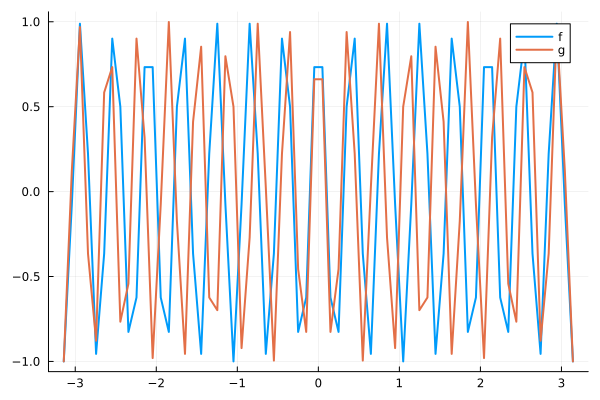

In [3]:
# parameters
N = 64                    # coarse grid (even)
L = π                     # half-domain ⇒ period 2π
x = range(-L, L; length=N)

# choose two wavenumbers near Nyquist (N/2 corresponds to highest resolvable integer mode on 2π)
k1 = 15
k2 = 17

f = cos.(k1 .* x)
g = cos.(k2 .* x)

p = plot(x, f, lw=2, label="f")
plot!(x, g, lw=2, label="g")
plot!(legend=:topright)


Aliasing when multiplying on the coarse grid

- Compute h = f .* g on the coarse grid
- Its true frequency content should include cos((k1+k2)x) and cos((k1−k2)x)
- If k1+k2 exceeds Nyquist, it will alias into a lower mode


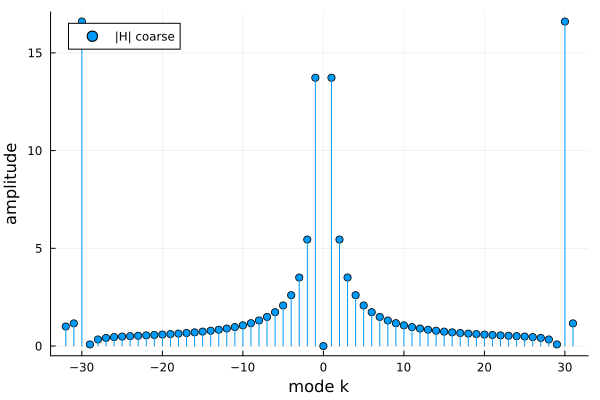

In [4]:
h_coarse = f .* g
Hc = fft(h_coarse)

# build frequency axis (integer modes for period 2π)
km = fftfreq_indices(N)
Hc_shift = fftshift(Hc)

p1 = plot(km, abs.(Hc_shift), seriestype=:stem, marker=:circle, label="|H| coarse")
xlabel!("mode k")
ylabel!("amplitude")
plot(p1)


3/2-rule zero padding: upsample → multiply → project back

Steps:
1) FFT of f, g on coarse grid (N)
2) Zero-pad spectra to M = 3N/2
3) IFFT to finer grid (M points), multiply there
4) FFT product, truncate back to N
5) IFFT to coarse grid and compare with aliased product


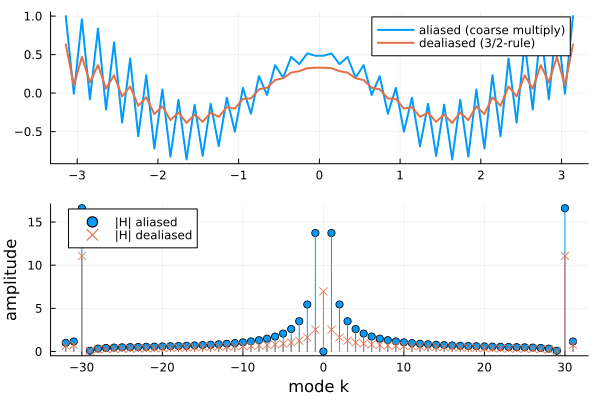

In [5]:
F = fft(f)
G = fft(g)

M = Int(ceil(3N/2))
Fp = pad_fourier(F, M)
Gp = pad_fourier(G, M)

# finer grid (implicitly corresponds to same period 2π)
fp = ifft(Fp)
gp = ifft(Gp)

hp = fp .* gp
Hp = fft(hp)

# project back to coarse
H_clean = truncate_fourier(Hp, N)
h_clean = real(ifft(H_clean))

# compare time domain
p2 = plot(x, h_coarse, lw=2, label="aliased (coarse multiply)")
plot!(x, h_clean, lw=2, label="dealiased (3/2-rule)")
plot!(legend=:topright)

# compare spectra (magnitude)
H_clean_shift = fftshift(H_clean)
p3 = plot(km, abs.(Hc_shift), seriestype=:stem, marker=:circle, label="|H| aliased")
plot!(km, abs.(H_clean_shift), seriestype=:stem, marker=:xcross, label="|H| dealiased")
xlabel!("mode k"); ylabel!("amplitude")
plot(p2, p3, layout=(2,1))


What to look for

- In the aliased spectrum, energy appears at wrong lower modes when k1+k2 exceeds Nyquist.
- With 3/2 padding, the coarse-band portion matches the true convolution; truncation removes out-of-band energy cleanly.
- In time domain, the dealiased product is smoother and matches what you would get on a much finer grid.
